## Домашние задания

2. *Реализуйте дерево для задачи регрессии. Возьмите за основу дерево, реализованное в методичке, заменив механизм предсказания в листе на взятие среднего значения по выборке, а критерий Джини на дисперсию значений.

In [1]:
import matplotlib.pyplot as plt
import random

from matplotlib.colors import ListedColormap
from sklearn import datasets

import numpy as np

In [2]:
class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [3]:
class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        prediction = np.mean(self.labels)
        return prediction  

In [4]:
def variance(labels):
    return labels.var()

In [5]:
def quality(left_labels, right_labels, current_var):

    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_var - p * variance(left_labels) - (1 - p) * variance(right_labels)

In [6]:
# Разбиение датасета в узле

def split(data, labels, index, t):
       
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [30]:
def find_best_split(data, labels):
    
    #  обозначим минимальное количество объектов в узле
    min_leaf = 10

    current_var = variance(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    for index in range(n_features):
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique([row[index] for row in data])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_var)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

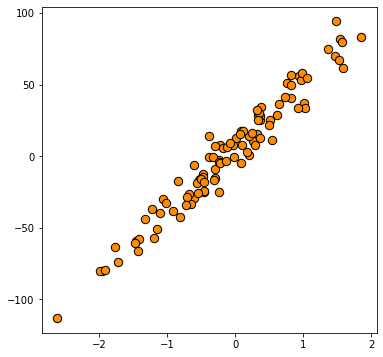

In [24]:
regression_data, regression_labels = datasets.make_regression(n_samples=100, 
                                                      n_features=1, bias=5, noise=10,
                                                      random_state=42)
plt.figure(figsize=(6,6))
plt.scatter(regression_data, regression_labels, c='darkorange', edgecolor='black', s=70);

In [25]:
from sklearn.model_selection import train_test_split

train_data, test_data, train_labels, test_labels = train_test_split(regression_data, 
                                                                    regression_labels, 
                                                                    test_size=0.3,
                                                                    random_state=42)

In [10]:
# Построение дерева с помощью рекурсивной функции

def build_tree(data, labels):

    quality, t, index = find_best_split(data, labels)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels)
    false_branch = build_tree(false_data, false_labels)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [11]:
def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [12]:
def predict(data, tree):
    values = []
    for obj in data:
        prediction = classify_object(obj, tree)
        values.append(prediction)
    return np.array(values)

In [19]:
def mse_metric(actual, predicted):
    return np.mean((actual - predicted) ** 2)

def r2_score(y, y_hat):
    y = np.array(y)
    y_hat = np.array(y_hat)
    return 1 - np.sum((y - y_hat)**2)/np.sum((y - y.mean())**2)

In [14]:
# Напечатаем ход нашего дерева
def print_tree(node, spacing=""):

    # Если лист, то выводим его прогноз
    if isinstance(node, Leaf):
        print(spacing + "Прогноз:", node.prediction)
        return

    # Выведем значение индекса и порога на этом узле
    print(spacing + 'Индекс', str(node.index))
    print(spacing + 'Порог', str(node.t))

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> True:')
    print_tree(node.true_branch, spacing + "  ")

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> False:')
    print_tree(node.false_branch, spacing + "  ")

In [31]:
my_tree = build_tree(train_data, train_labels)
train_answers = predict(train_data, my_tree)
test_answers = predict(test_data, my_tree)
print_tree(my_tree)

Индекс 0
Порог -0.22577630048653566
--> True:
  Индекс 0
  Порог -1.0577109289559004
  --> True:
    Прогноз: -67.07466641448633
  --> False:
    Индекс 0
    Порог -0.5443827245251827
    --> True:
      Прогноз: -29.379027398981357
    --> False:
      Прогноз: -11.57963671279447
--> False:
  Индекс 0
  Порог 0.6476885381006925
  --> True:
    Индекс 0
    Порог 0.29612027706457605
    --> True:
      Прогноз: 6.914107894919067
    --> False:
      Прогноз: 23.655429936153077
  --> False:
    Прогноз: 64.81112319328726


In [32]:
train_mse = mse_metric(train_labels, train_answers)
train_r2 = r2_score(train_labels, train_answers)
train_mse, train_r2

(151.25822561100603, 0.9072717355231827)

In [33]:
test_mse = mse_metric(test_labels, test_answers)
test_r2 = r2_score(test_labels, test_answers)
test_mse, test_r2

(255.563762358726, 0.8540271618192617)

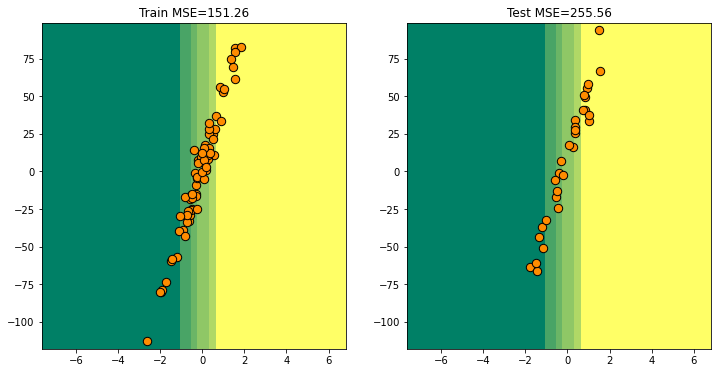

In [34]:
def get_meshgrid(data, labels, step=.05, border=5):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = labels.min() - border, labels.max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

plt.figure(figsize = (12, 6))
#colors = ListedColormap(['red', 'blue'])
#light_colors = ListedColormap(['lightgreen', 'lightblue'])

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy = get_meshgrid(regression_data, regression_labels)
mesh_predictions = np.array(predict(np.c_[xx.ravel(), yy.ravel()], my_tree)).reshape(xx.shape)
#plt.plot(xx, yy, color="yellowgreen", linewidth=2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = 'summer')
plt.scatter(train_data[:, 0], train_labels, c='darkorange', edgecolor='black', s=70)
plt.title(f'Train MSE={train_mse:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = 'summer')
#plt.scatter(test_data, predict(sorted(test_data), my_tree), color="yellowgreen")
plt.scatter(test_data[:, 0], test_labels, c='darkorange', edgecolor='black', s=70)
plt.title(f'Test MSE={test_mse:.2f}');